In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [6]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
            i += 1
        return df

In [7]:
df = read_csv_replace_missing_by_polynomial('pib_mato_grosso.csv', 0, 0)
df.head(len(df))

,Ano,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - PIB - Preços de Mercado
0,1985,1.329840e+07,1.632986e+06,11.509292,2.828409e+07
1,1986,1.521281e+07,1.716526e+06,11.863417,2.977640e+07
2,1987,1.749431e+07,1.797814e+06,12.267255,3.142620e+07
3,1988,2.001038e+07,1.895699e+06,12.681546,3.310636e+07
4,1989,2.271658e+07,2.005333e+06,13.078173,3.475925e+07
5,1990,2.574363e+07,2.118647e+06,13.492201,3.644203e+07
6,1991,2.889194e+07,2.229741e+06,13.889995,3.806070e+07
7,1992,3.238927e+07,2.313968e+06,14.296569,3.971671e+07
8,1993,3.579266e+07,2.379749e+06,14.636159,4.119310e+07
9,1994,3.939690e+07,2.434734e+06,14.969330,4.267593e+07


In [8]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year

,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - PIB - Preços de Mercado
Ano,,,,
1985,1.329840e+07,1.632986e+06,11.509292,2.828409e+07
1986,1.521281e+07,1.716526e+06,11.863417,2.977640e+07
1987,1.749431e+07,1.797814e+06,12.267255,3.142620e+07
1988,2.001038e+07,1.895699e+06,12.681546,3.310636e+07
1989,2.271658e+07,2.005333e+06,13.078173,3.475925e+07
1990,2.574363e+07,2.118647e+06,13.492201,3.644203e+07
1991,2.889194e+07,2.229741e+06,13.889995,3.806070e+07
1992,3.238927e+07,2.313968e+06,14.296569,3.971671e+07
1993,3.579266e+07,2.379749e+06,14.636159,4.119310e+07


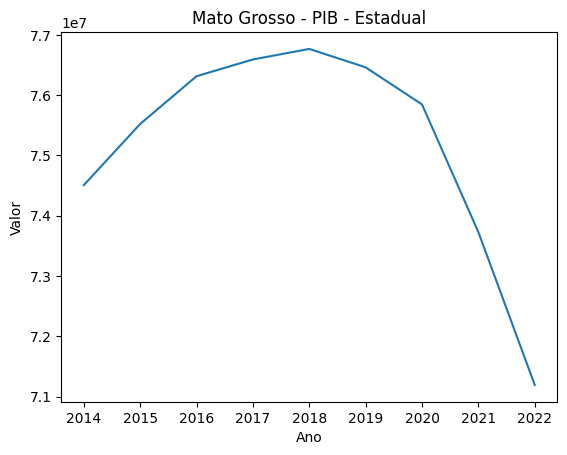

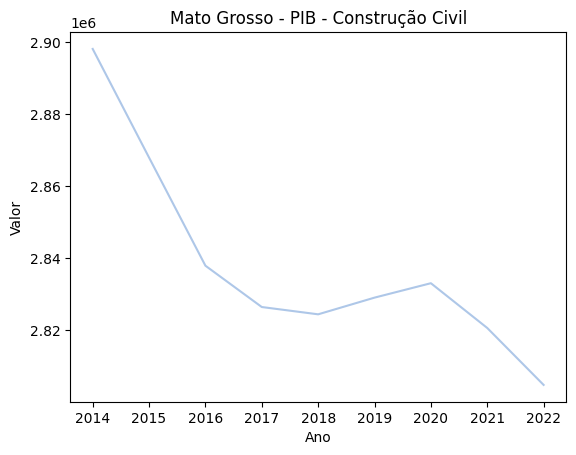

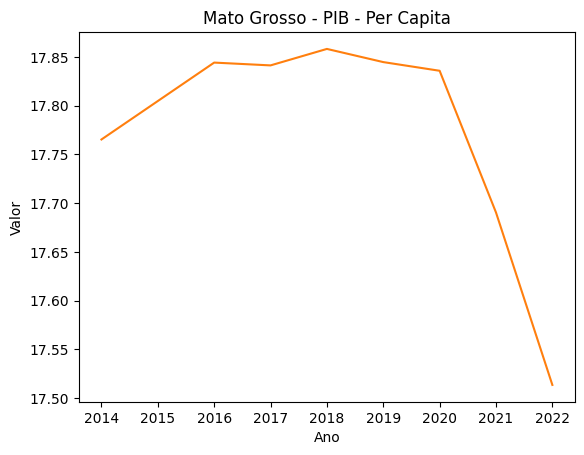

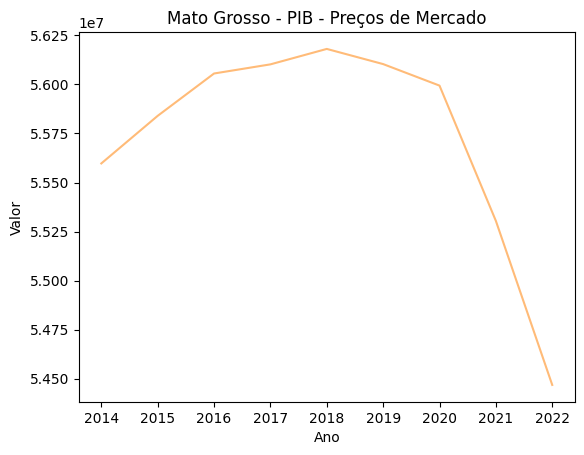

,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - PIB - Preços de Mercado
Ano,,,,
2014,7.450695e+07,2.898181e+06,17.765377,5.559725e+07
2015,7.552129e+07,2.867943e+06,17.804826,5.583983e+07
2016,7.631332e+07,2.837856e+06,17.844276,5.605555e+07
2017,7.659073e+07,2.826355e+06,17.841399,5.610212e+07
2018,7.676559e+07,2.824325e+06,17.858303,5.618080e+07
2019,7.645988e+07,2.828969e+06,17.844789,5.610350e+07
2020,7.584496e+07,2.832984e+06,17.835880,5.599389e+07
2021,7.372752e+07,2.820526e+06,17.690471,5.530452e+07
2022,7.119278e+07,2.804678e+06,17.513528,5.446856e+07


In [9]:
df_2014 = df_year[df_year.index >= 2014]
plot_columns(df_2014)
df_2014

In [10]:
df_2014.to_csv('2014_01_pib.csv')

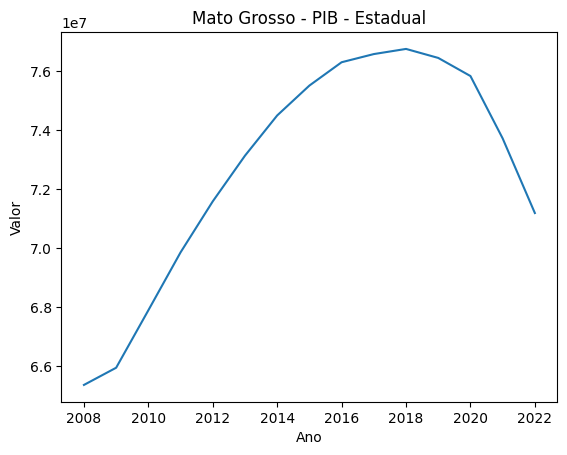

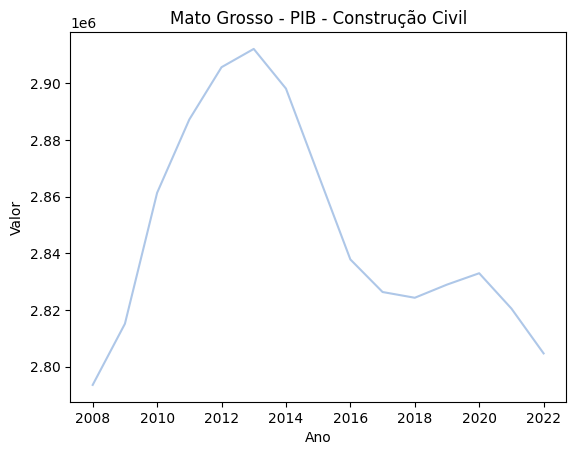

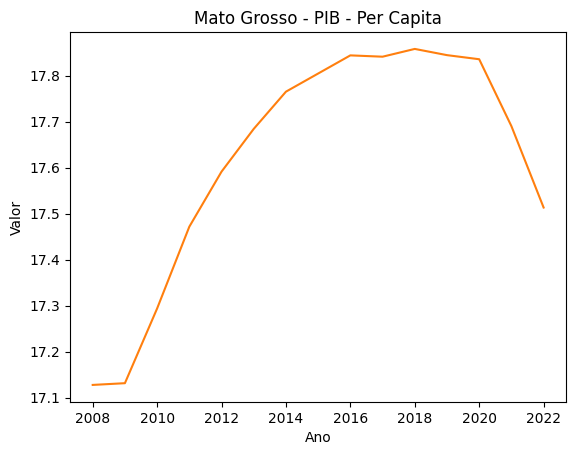

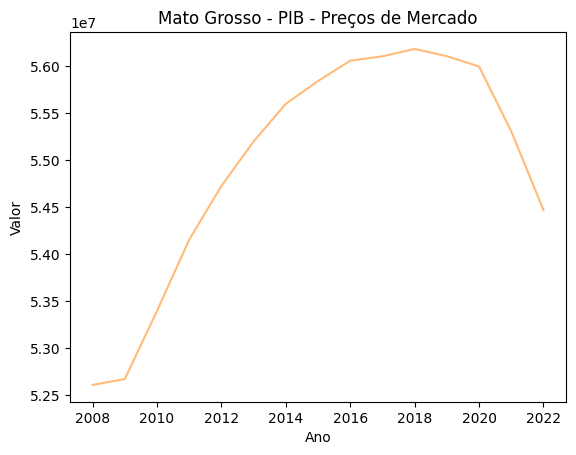

,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - PIB - Preços de Mercado
Ano,,,,
2008,6.535602e+07,2.793553e+06,17.127903,5.260918e+07
2009,6.593967e+07,2.815133e+06,17.131657,5.267158e+07
2010,6.789156e+07,2.861375e+06,17.294037,5.339572e+07
2011,6.985811e+07,2.887266e+06,17.471861,5.415240e+07
2012,7.159016e+07,2.905726e+06,17.591515,5.472408e+07
2013,7.314074e+07,2.912179e+06,17.684470,5.519726e+07
2014,7.450695e+07,2.898181e+06,17.765377,5.559725e+07
2015,7.552129e+07,2.867943e+06,17.804826,5.583983e+07
2016,7.631332e+07,2.837856e+06,17.844276,5.605555e+07


In [10]:
df_2008 = df_year[df_year.index >= 2008]
plot_columns(df_2008)
df_2008

In [11]:
df_2008.to_csv('2008_01_pib.csv')